## **Overview**
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**



In [1]:
import matplotlib
import warnings
# 忽略警告
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络
from numpy import array
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Bidirectional
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob
import tensorflow as tf
from tensorflow.python.keras.layers import Activation
from keras import optimizers
from pygame import mixer
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

pygame 2.5.1 (SDL 2.28.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
def read_someone_day_file(day):
    IMF = []
    xlsx_file = '../../Data/CEEMDAN/58606_2/'+day+'/'
    xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))

    data_col_len = pd.read_excel('../../Data/CEEMDAN/58606_2/'+day+'/CEEMDAN_58606 Station_g.xlsx',header=None)

    for imf_len in range(len(data_col_len.columns)):
        for file in xlsx_path:
             print(file)
             # print(os.path.basename(file))
             imfs = pd.read_excel(file,header=None)
             imfn = imfs.iloc[:,imf_len]
             imfn.to_numpy()
             IMF.append(imfn )
        print(imf_len,"-------------------")
    return IMF

In [5]:
def Result_Ana(Model, feature_num,testX,testY,scaler):
    print('Result_Ana_Function:',testX.shape)
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    # 将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    prediction_copies_array
    print('-----------prediction copy Shape：',prediction_copies_array.shape,'------------------')
    # Multi Var prediction
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列
    # Single prediction
    # pred = scaler.inverse_transform(y_pred) #进行逆变换但是，只需要最后一列

    # print(pred)
    print('testY of shape :',testY.shape)
    y_true = np.array(testY).reshape(-1, 1)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    print('IMF_True:',scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num))))
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]

    print('feature_num-1_ETO_true:',y_true)

    # Single true value
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    # y_true
    # pred

    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ETO (mm)')
    plt.xlabel('Time (day)')
    plt.ylabel('ETO (mm)')
    plt.legend()
    plt.show()


    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return y_true,pred

In [6]:
def ceemdan_lstm(day):
    mixer.init()
    mixer.music.load('../../Resources/ExecuteTipAudio.mp3')

    reshape1 = 0
    IMF = read_someone_day_file(day)

    imf_choose = 0
    finally_rsult = []
    finally_y_true = []

    for imf_run in range(int(len(IMF) / 7)):
        ALL_Factor_IMF = IMF[imf_choose:imf_choose+7][:]
        imf_choose = imf_choose + 7

        print('--------------------------',imf_run,'--------------------------')
        ALL_Factor_IMF = np.array(ALL_Factor_IMF)
        IMF_Input = np.transpose(ALL_Factor_IMF)

        df_IMF = pd.DataFrame(IMF_Input)
        df_IMF.columns = ['one','two','three','four','five','six', 'seven']

        print(df_IMF)

        scaler = MinMaxScaler(feature_range=(0, 1))
        df = scaler.fit_transform(df_IMF)

        sacler_data_len = len(df_IMF.columns)

        #数据集划分
        test_split = round(len(df) * 0.20)
        print(test_split)
        def splitData(var, per_test):
            num_test = int(len(var) * per_test)
            train_size = int(len(var) - num_test)
            train_data = var[0:train_size]
            test_data = var[train_size:train_size + num_test]
            return train_data, test_data


        df_training, df_testing = splitData(df, 0.2)
        print('df_training.shape:',df_training.shape)
        print('df_testing.shape:',df_testing.shape)

        def createXY(data,n_past,n_steps_out):
            dataX,dataY = list(),list()

            for i in range(len(data)):
                ## such as: len(data) = 19624
                end_ix = i + n_past ## 0+3=3,1+3=4,...,19618+3=19621
                out_end_ix = end_ix + n_steps_out ## 3+3=6,4+3=7,...,19621+3=19624
                # print('out_end_ix:',out_end_ix)
                '''
                加入此处判断，使得最终的dataX和dataY中每行的数组长度一致，进而可以转换为array(数组),如若不加以限制，
                则导致最后几次循环由于i是在len(data)范围内的，
                但是由于out_end_ix=end_ix + n_steps_out,最终会超出data的数据范围，而导致其无法获取到数据,
                加入dataY之后，最后几行的数据长度是和前面的数据长度不一致，最终导致无法进行array转换
                '''
                if out_end_ix > len(data): ## 6 < len(data),7<len(data),...,19623+3=19626>len(data)=19624
                    # print("------------out_end_ix of end",out_end_ix,'---------------')
                    break

                dataX.append(data[i:end_ix,0:data.shape[1]]) ## 0:3,0:7;1:4,0:7
                dataY.append(data[end_ix:out_end_ix,data.shape[1]-1]) ##3:6,6;4:7,6
            return np.array(dataX), np.array(dataY)

        n_past=1
        n_steps_out=1

        trainX, trainY = createXY(df_training, n_past, n_steps_out)
        testX, testY = createXY(df_testing, n_past, n_steps_out)

        reshape1 = testY.shape[0]

        print('trainX.Shape:----', trainX.shape)
        print('trainY.shape:----', trainY.shape)
        print('testX.shape:----', testX.shape)
        print('testY.shape:----', testY.shape)

        # trainY = trainY.reshape(-1)
        # testY = testY.reshape(-1)
        # print('trainY Shape 2 ---', trainY.shape)
        # print('testY Shape 2 ---', testY.shape)
        # trainX = np.expand_dims(trainX,axis=1)
        # testX = np.expand_dims(testX,axis=1)
        # print('expand_dims_trainX of shape',trainX.shape)
        # print('expand_dims_testX of shape',testX.shape)

        print('----------------------------',imf_run,'------------------------------')

        def N_LSTM(batch_size=32, epochs=40):
                model = Sequential()
                model.add(LSTM(200, activation='relu', input_shape=(n_past, 7)))
                # model.add(LSTM(100,activation='relu'))
                #model.add(CuDNNLSTM(200, return_sequences=True, input_shape=(None, sacler_data_len)))

                # model.add(LSTM(50, activation='relu'))
                model.add(Dropout(0.1))
                # model.add(LSTM(50, activation='relu'))
                # model.add(Dropout(0.1))

                # opm_adam = Adam(lr=0.01)  # 设置为您希望的学习率
                # model.add(Dense(1))
                ## Full connection layer: This is output shape(e.g. 3 Dimension that trainY.shape[1] = 3 represent for each output is 3 number)
                model.add(Dense(1))

                model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

                return model

        N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))
        # N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1)

        from sklearn.model_selection import GridSearchCV

        # 定义超参数搜索范围
        param_grid = {
            # 'optimizer': ['adam'],
            'batch_size': [128, 256],
            'epochs': [20,30]
            # 'batch_size': [64],
            # 'epochs': [40]
        }

        # 执行网格搜索
        grid = GridSearchCV(estimator=N_LSTM_Model, param_grid=param_grid, cv=2)
        grid_result = grid.fit(trainX, trainY)


        best_params = grid_result.best_params_

        best_params
        print('prediction' , 'one' ,'day best_params:', best_params)

        best_model = grid_result.best_estimator_

        y_trues,prediction_result = Result_Ana(best_model, sacler_data_len,testX,testY,scaler)

        print('prediction_result:',prediction_result)
        finally_rsult.append(prediction_result)
        print('lstm_y_turs:',y_trues)
        finally_y_true.append(y_trues)

        mixer.music.play()
        time.sleep(1)
        mixer.music.stop()
    return reshape1,finally_y_true,finally_rsult,day

In [7]:
def plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day):
    # WL(Water Level(m)) For IMF1-IMF13-R True Value
    finally_y_true
    finally_ytrue_r = np.array(finally_y_true)
    finally_ytrue_r
    reshape2 = len(finally_ytrue_r)
    reshape2
    finally_column_names = []

    for i in range(1, reshape2 + 1):
        if i < (reshape2):
            finally_column_names.append("IMF" + str(i))
        else:
            finally_column_names.append("Residual")
    finally_column_names
    ALL_Factor_ReIMFS_Yture_Result = np.transpose(finally_ytrue_r)
    reshape1
    ALL_Factor_ReIMFS_Yture_Result = ALL_Factor_ReIMFS_Yture_Result.reshape(reshape1, reshape2)
    all_factor_ceemdan_true = pd.DataFrame(ALL_Factor_ReIMFS_Yture_Result, columns=finally_column_names)
    all_factor_ceemdan_true
    sums = all_factor_ceemdan_true.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_true["True"] = sums
    # 保存为CSV文件
    true_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-LSTM_true.csv"

    all_factor_ceemdan_true.to_csv(true_file_path,
                                   index=False)
    # WL(Water Level(m)) IMF1-IMF13-R Prediction Value
    finally_rsult
    finally_r = np.array(finally_rsult)
    finally_r
    ALL_Factor_ReIMFS_Result = np.transpose(finally_r)
    ALL_Factor_ReIMFS_Result = ALL_Factor_ReIMFS_Result.reshape(reshape1, reshape2)
    finally_column_names
    all_factor_ceemdan_prediction = pd.DataFrame(ALL_Factor_ReIMFS_Result, columns=finally_column_names)
    all_factor_ceemdan_prediction
    sums = all_factor_ceemdan_prediction.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_prediction["Pred"] = sums
    prediction_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-LSTM_prediction.csv"
    # 保存为CSV文件
    all_factor_ceemdan_prediction.to_csv(prediction_file_path, index=False)
    ### 验证最终结果
    df = pd.read_csv(prediction_file_path)
    df = df[['Pred']]
    df

    origin = pd.read_csv(true_file_path)
    origin = origin[['True']]
    # y_true = origin.iloc[:,len(origin.columns)-1]
    y_true = origin
    y_true
    pred = df
    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ET0 ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2

    print('MSE:', mse(y_true, pred))
    print('MAE:', mae(y_true, pred))
    print('R²:', r2(y_true, pred))
    print('RMSE:', np.sqrt(mse(y_true, pred)))
    print('pred_finally:', pred)

------------------ OneDay --------------------
This is  OneDay -th for prediction et0
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
1 --------

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


Epoch 1/20
77/77 [==============================] - 1s 5ms/step - loss: 0.0590 - mae: 0.1868 - val_loss: 0.0148 - val_mae: 0.0901
Epoch 2/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0134 - mae: 0.0864 - val_loss: 0.0135 - val_mae: 0.0856
Epoch 3/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0822 - val_loss: 0.0126 - val_mae: 0.0826
Epoch 4/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0115 - mae: 0.0800 - val_loss: 0.0124 - val_mae: 0.0815
Epoch 5/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0786 - val_loss: 0.0123 - val_mae: 0.0813
Epoch 6/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0111 - mae: 0.0786 - val_loss: 0.0122 - val_mae: 0.0808
Epoch 7/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0111 - mae: 0.0782 - val_loss: 0.0121 - val_mae: 0.0806
Epoch 8/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0110 - mae: 0.07

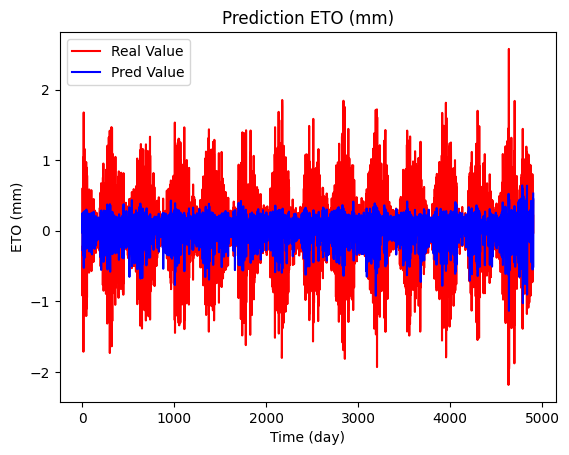

MSE: 0.26166136298924203
MAE: 0.3733565812356269
R²: 0.05165366916235459
RMSE: 0.5115284576533763
pred_finally: [-0.27391827  0.05421992  0.24928938 ...  0.46298307 -0.5204095
  0.5262305 ]
prediction_result: [-0.27391827  0.05421992  0.24928938 ...  0.46298307 -0.5204095
  0.5262305 ]
lstm_y_turs: [-0.22846669 -0.9194061   0.47041622 ...  0.22694627 -0.03973494
  0.43138383]
-------------------------- 1 --------------------------
            one       two     three      four      five            six  \
0     -0.717649 -0.700243 -1.302272  1.167898  2.246833    -266.541681   
1     -0.067041  0.133359 -1.809280  1.549877  0.945760    -702.111248   
2      0.406846  0.474059 -0.593264  1.616759  0.143621    -308.938576   
3      0.233040  0.235515  1.043773  1.200236 -0.919376     127.959321   
4     -0.127228 -0.141003  1.191214  0.368845 -0.945895      63.058347   
...         ...       ...       ...       ...       ...            ...   
24525  0.130000  0.020085 -0.993216  0.027438 -

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 1s 5ms/step - loss: 0.0526 - mae: 0.1597 - val_loss: 0.0024 - val_mae: 0.0315
Epoch 2/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0334 - val_loss: 0.0022 - val_mae: 0.0286
Epoch 3/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0326 - val_loss: 0.0022 - val_mae: 0.0283
Epoch 4/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0321 - val_loss: 0.0022 - val_mae: 0.0279
Epoch 5/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0321 - val_loss: 0.0021 - val_mae: 0.0274
Epoch 6/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0021 - mae: 0.0318 - val_loss: 0.0021 - val_mae: 0.0269
Epoch 7/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0313 - val_loss: 0.0020 - val_mae: 0.0268
Epoch 8/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0310 - val_lo

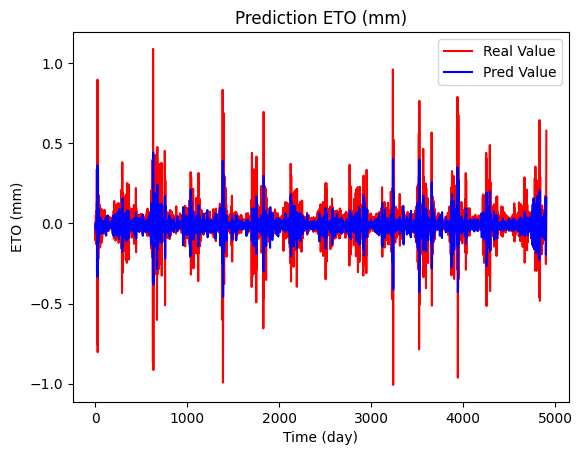

MSE: 0.00984422731466184
MAE: 0.05877990804012048
R²: 0.2824826483358077
RMSE: 0.09921807957555841
pred_finally: [ 0.00319538 -0.0266863  -0.03533844 ...  0.08257163  0.11927097
  0.16137686]
prediction_result: [ 0.00319538 -0.0266863  -0.03533844 ...  0.08257163  0.11927097
  0.16137686]
lstm_y_turs: [-0.01562149 -0.10756524 -0.02491552 ...  0.08294097  0.29797894
  0.57746203]
-------------------------- 2 --------------------------
            one       two     three      four      five            six  \
0     -0.341676  0.979711 -1.181582  0.350818  2.414864     -59.147632   
1     -0.104460  1.669276 -1.545486  0.553184  1.936741    1205.856175   
2     -0.321276  1.773475 -0.876626  0.632451 -0.862360     165.532785   
3     -0.536460  0.647876  0.331070  0.421779 -3.845997   -1139.985967   
4     -0.454172 -0.598511  1.085067  0.130059 -4.377561      37.511552   
...         ...       ...       ...       ...       ...            ...   
24525 -0.816230 -0.477108 -1.100900 -0.07032

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 1s 5ms/step - loss: 0.0673 - mae: 0.1928 - val_loss: 0.0056 - val_mae: 0.0548
Epoch 2/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0534 - val_loss: 0.0050 - val_mae: 0.0514
Epoch 3/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0046 - mae: 0.0510 - val_loss: 0.0043 - val_mae: 0.0479
Epoch 4/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0492 - val_loss: 0.0039 - val_mae: 0.0460
Epoch 5/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0040 - mae: 0.0480 - val_loss: 0.0038 - val_mae: 0.0456
Epoch 6/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0040 - mae: 0.0485 - val_loss: 0.0037 - val_mae: 0.0457
Epoch 7/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0479 - val_loss: 0.0037 - val_mae: 0.0452
Epoch 8/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0038 - mae: 0.0473 - val_lo

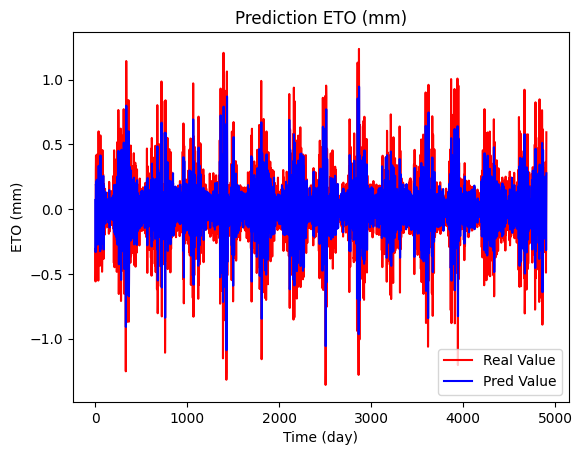

MSE: 0.036611992702128
MAE: 0.14325617557385437
R²: 0.524164580317062
RMSE: 0.19134260555905472
pred_finally: [ 0.07121819 -0.18433572 -0.33074474 ... -0.12161831  0.08725653
  0.2774257 ]
prediction_result: [ 0.07121819 -0.18433572 -0.33074474 ... -0.12161831  0.08725653
  0.2774257 ]
lstm_y_turs: [-0.30608954 -0.55767852 -0.47324348 ...  0.16486849  0.46517182
  0.59421051]
-------------------------- 3 --------------------------
            one       two     three      four      five            six  \
0     -0.661736  1.203007 -1.923127  0.080471 -1.565418    -384.149923   
1     -0.802548  1.606931 -2.090151  0.157180 -2.150125     245.882729   
2     -0.699025  1.505821 -1.652161  0.134042 -2.440051     507.008948   
3     -0.725270  0.975604 -0.892493  0.064260 -2.023263     -16.046745   
4     -0.697584  0.506975 -0.079269 -0.015150 -0.811144    -337.765596   
...         ...       ...       ...       ...       ...            ...   
24525 -0.376335 -1.304232 -0.481655 -0.090300  

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 1s 5ms/step - loss: 0.0484 - mae: 0.1558 - val_loss: 0.0054 - val_mae: 0.0566
Epoch 2/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0514 - val_loss: 0.0043 - val_mae: 0.0501
Epoch 3/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 0.0028 - val_mae: 0.0405
Epoch 4/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0413 - val_loss: 0.0024 - val_mae: 0.0378
Epoch 5/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0401 - val_loss: 0.0022 - val_mae: 0.0367
Epoch 6/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0392 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 7/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0387 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 8/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0024 - mae: 0.0383 - val_lo

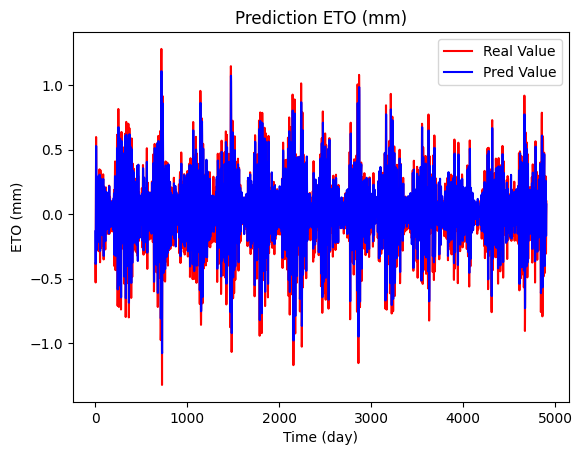

MSE: 0.018196893813568833
MAE: 0.10333234821304298
R²: 0.7861616900530561
RMSE: 0.13489586284823132
pred_finally: [-0.13358738 -0.2924968  -0.38592082 ... -0.09427405 -0.00356458
  0.07497823]
prediction_result: [-0.13358738 -0.2924968  -0.38592082 ... -0.09427405 -0.00356458
  0.07497823]
lstm_y_turs: [-0.38186312 -0.51136228 -0.53018441 ... -0.07308708  0.03796344
  0.09813321]
-------------------------- 4 --------------------------
            one       two     three      four      five           six  \
0     -0.389531  0.586490 -0.654795 -0.110076  2.704542    172.547296   
1     -0.353339  0.560630 -0.630126 -0.125011  2.992187    292.905825   
2     -0.351755  0.394267 -0.444077 -0.086728  3.231139    551.059783   
3     -0.358551  0.163739 -0.154264 -0.028367  3.278532    755.747424   
4     -0.321253 -0.128788  0.188916  0.016481  3.004265    678.752445   
...         ...       ...       ...       ...       ...           ...   
24525  0.433728  0.718367  1.196502  0.126054 -5.3

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 1s 5ms/step - loss: 0.0503 - mae: 0.1616 - val_loss: 0.0052 - val_mae: 0.0541
Epoch 2/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0028 - val_mae: 0.0389
Epoch 3/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0023 - mae: 0.0372 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 4/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0018 - mae: 0.0330 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 5/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0316 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 6/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0309 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 7/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 8/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0293 - val_lo

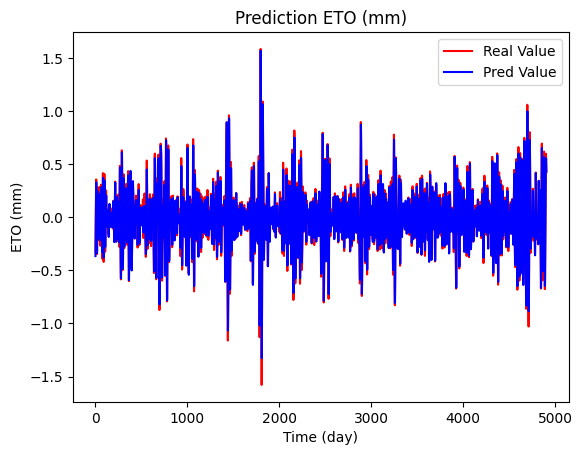

MSE: 0.006232054238033384
MAE: 0.0600019808484691
R²: 0.9208764587824823
RMSE: 0.07894336094969218
pred_finally: [-0.365259   -0.3395094  -0.26011017 ...  0.52711326  0.4788518
  0.4349066 ]
prediction_result: [-0.365259   -0.3395094  -0.26011017 ...  0.52711326  0.4788518
  0.4349066 ]
lstm_y_turs: [-0.33046399 -0.26250496 -0.15866618 ...  0.50942294  0.46093815
  0.42654371]
-------------------------- 5 --------------------------
            one       two     three      four      five           six  \
0     -0.826169 -1.337820  0.515877 -0.021205 -1.880795  -1238.158886   
1     -0.901505 -1.384742  0.647517 -0.022810 -1.979773  -1255.023748   
2     -0.934304 -1.401546  0.774530 -0.041143 -2.080201  -1263.141402   
3     -0.909293 -1.391681  0.891331 -0.073654 -2.165465  -1253.146649   
4     -0.825918 -1.374637  0.992247 -0.116823 -2.215935  -1218.249177   
...         ...       ...       ...       ...       ...           ...   
24525  0.123502 -0.367083 -0.808054 -0.015135  1.6696

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 1s 5ms/step - loss: 0.0552 - mae: 0.1661 - val_loss: 0.0037 - val_mae: 0.0471
Epoch 2/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0034 - mae: 0.0464 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 3/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0024 - mae: 0.0388 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 4/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0018 - mae: 0.0332 - val_loss: 9.8123e-04 - val_mae: 0.0243
Epoch 5/20
77/77 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0309 - val_loss: 9.1203e-04 - val_mae: 0.0234
Epoch 6/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0303 - val_loss: 8.5168e-04 - val_mae: 0.0225
Epoch 7/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0296 - val_loss: 8.1624e-04 - val_mae: 0.0221
Epoch 8/20
77/77 [==============================] - 0s 4ms/step - loss: 0.0013 - mae:

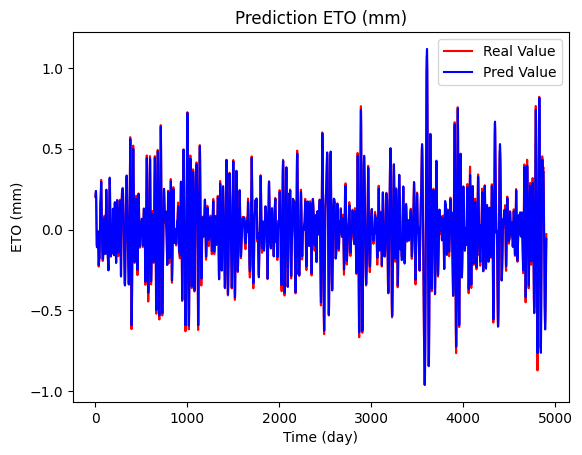

MSE: 0.001968554635968418
MAE: 0.03416969826837959
R²: 0.9687836396254441
RMSE: 0.044368396815395734
pred_finally: [ 0.20587887  0.21264698  0.21923682 ... -0.14296788 -0.09140238
 -0.05570627]
prediction_result: [ 0.20587887  0.21264698  0.21923682 ... -0.14296788 -0.09140238
 -0.05570627]
lstm_y_turs: [ 0.20117115  0.20871215  0.21738666 ... -0.05924301 -0.03032325
 -0.02786112]
-------------------------- 6 --------------------------
            one       two     three      four      five           six  \
0      1.928907  1.199636  0.270012 -0.869554 -1.364838  -1616.392266   
1      1.949215  1.249280  0.288430 -0.873038 -1.372098  -1692.993038   
2      1.959629  1.308219  0.310103 -0.868264 -1.354231  -1744.598684   
3      1.962431  1.375429  0.334793 -0.855393 -1.312153  -1770.009776   
4      1.959622  1.450769  0.360931 -0.834913 -1.248742  -1768.183721   
...         ...       ...       ...       ...       ...           ...   
24525 -0.982413 -0.737453 -0.779654 -0.176705  3.

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_19436\78137934.py:111: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1, validation_data=(testX, testY))


77/77 [==============================] - 2s 11ms/step - loss: 0.0577 - mae: 0.1783 - val_loss: 0.0083 - val_mae: 0.0687
Epoch 2/20
77/77 [==============================] - 0s 6ms/step - loss: 0.0073 - mae: 0.0650 - val_loss: 0.0050 - val_mae: 0.0528
Epoch 3/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 0.0022 - val_mae: 0.0353
Epoch 4/20
77/77 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0387 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 5/20
71/77 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0352

In [8]:
%%time
if __name__ == '__main__':
    days = ['OneDay','ThreeDay','FiveDay','FifteenDay']
    for day in days:
       print('------------------',day ,'--------------------')
       print('This is ',day,'-th for prediction et0')
       reshape1,finally_y_true,finally_rsult,day = ceemdan_lstm(day)
       print('This is ',day,'-th for prediction et0')
       print('------------------',day,'---------------------')
       plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day)